In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
connection = {'database': 'default',
             'host': 'http://clickhouse.lab.karpov.courses',
             'user': 'student',
             'password': 'dpo_python_2020'}

In [ ]:
#Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: 
#выведите количество строк в таблице ldn_listings.

In [3]:
query = """
SELECT COUNT() 
FROM(SELECT * 
FROM default.ldn_listings)
"""

In [4]:
ph.read_clickhouse(query, connection = connection)

,count()
0,85207


In [ ]:
#Выгрузите из таблицы данные о цене в зависимости от типа жилья.
#Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.
#Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.
#В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [5]:
query2= """
SELECT toFloat32OrNull(replaceAll(replaceAll(price, ',',''), '$', '')) AS price, room_type
FROM default.ldn_listings
ORDER BY id
LIMIT 1000
"""

In [8]:
df = ph.read_clickhouse(query2, connection = connection)
df.head()

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt


In [32]:
df.groupby('room_type', as_index = False).quantile(q = 0.75).query('room_type == "Private room"').price

2    70.0
Name: price, dtype: float64

In [ ]:
#К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
#В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.
#Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [37]:
query3= """
SELECT 
    toFloat32OrNull(replaceAll(replaceAll(price, ',',''), '$', '')) AS price, 
    room_type,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM default.ldn_listings
WHERE review_scores_rating is not Null
LIMIT 1000
"""

In [38]:
df3 = ph.read_clickhouse(query3, connection = connection)
df3.head()

,price,room_type,review_scores_rating
0,65.0,Private room,97.0
1,100.0,Entire home/apt,96.0
2,300.0,Entire home/apt,94.0
3,65.0,Entire home/apt,93.0
4,29.0,Private room,96.0


In [50]:
df_result = df3.groupby('room_type', as_index = False).agg({'price': 'mean','review_scores_rating':'mean'}) \
    .rename(columns= {'price':'mean_price','review_scores_rating':'mean_review_scores_rating'})
df_result

,room_type,mean_price,mean_review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


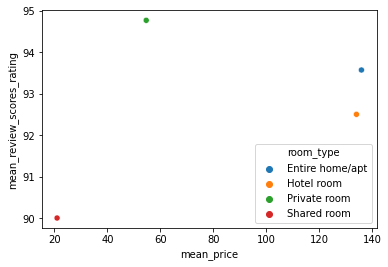

In [52]:
sns.scatterplot(data = df_result, y = 'mean_review_scores_rating', x = 'mean_price', hue = 'room_type')

In [ ]:
#Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.
#Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления
#(experiences_offered != 'none').
#Для каждого уникального пользователя выгрузите только две колонки:
#host_id – идентификатор хозяина (уникальный), host_verifications – какими способами хост подтвердил свой профиль
#Затем обработайте столбец host_verifications. 
#Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта
#Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

#Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [126]:
query4= """
SELECT 
    DISTINCT host_id,
    host_verifications
FROM default.ldn_listings
WHERE experiences_offered != 'none'
"""

In [127]:
df4 = ph.read_clickhouse(query4, connection = connection)
df4.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [128]:
df4['host_verifications'] = df4['host_verifications'].apply(lambda x: eval(x.strip()))

In [133]:
result = df4.explode('host_verifications').host_verifications.value_counts().to_frame(name = 'count')
result

,count
phone,1361
email,1345
reviews,1309
government_id,1196
jumio,1115
offline_government_id,469
work_email,279
facebook,270
selfie,252
identity_manual,227


In [139]:
result[result.index == 'google']

,count
google,34


In [165]:
#Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 
#Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.
#Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. 
#Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, 
#а значения – число объявлений с таким впечатлением для каждого района. 
#Визуализируйте результат с помощью sns.heatmap()

In [153]:
query5= """
SELECT 
    neighbourhood_cleansed,
    experiences_offered, 
    COUNT(host_verifications) experiences_count
FROM default.ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""

In [155]:
df5 = ph.read_clickhouse(query5, connection = connection)
df5.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [159]:
pivot_table= df5.pivot(index = 'neighbourhood_cleansed',  columns= 'experiences_offered', values = 'experiences_count')
pivot_table.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


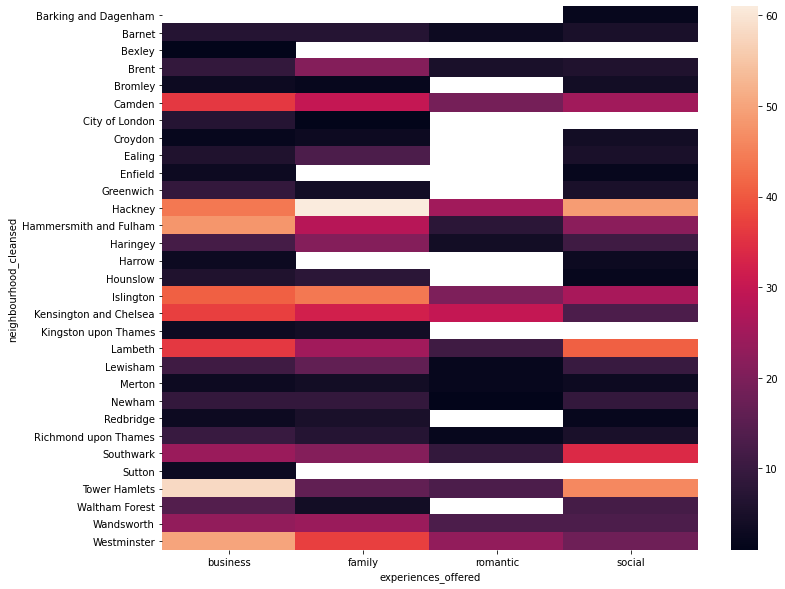

In [164]:
plt.figure(figsize = (12,10))
cmap=sns.cubehelix_palette(as_cmap=True)
sns.heatmap(data = pivot_table)


In [ ]:
#Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 
#Далее постройте два графика, используя distplot из библиотеки seaborn:
#На первом отобразите исходные распределения цен для каждого типа жилья
#На втором – логарифмированные значения (np.log())

In [5]:
query6= """
SELECT 
    room_type,
    toFloat32OrNull(replaceAll(replaceAll(price, ',',''), '$', '')) price 
FROM default.ldn_listings
WHERE experiences_offered != 'none' 

"""

In [6]:
df6 = ph.read_clickhouse(query6, connection = connection)
df6.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [8]:
df6.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

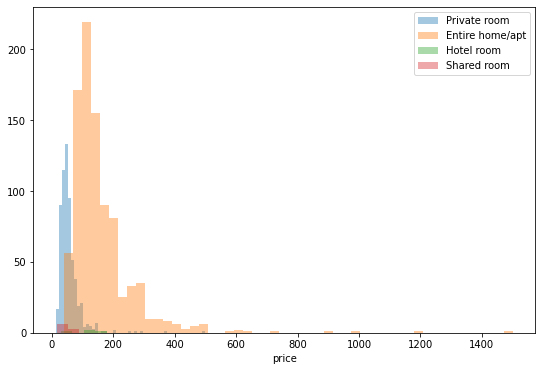

In [19]:
plt.figure(figsize= (9,6))
sns.distplot(df6.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df6.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df6.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df6.query("room_type=='Shared room'").price, kde=False, label='Shared room')    
plt.legend()
plt.show()

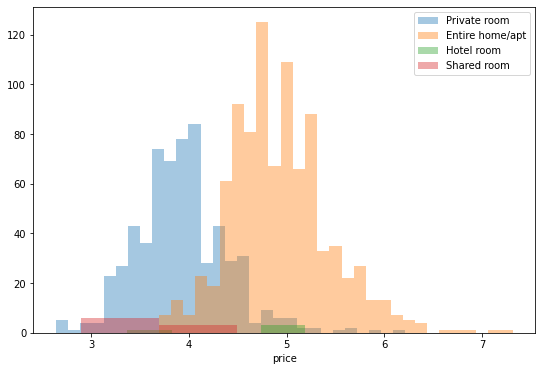

In [33]:
plt.figure(figsize= (9,6))
sns.distplot(np.log(df6.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df6.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df6.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df6.query("room_type=='Shared room'").price), kde=False, label='Shared room')     
plt.legend()
plt.show()

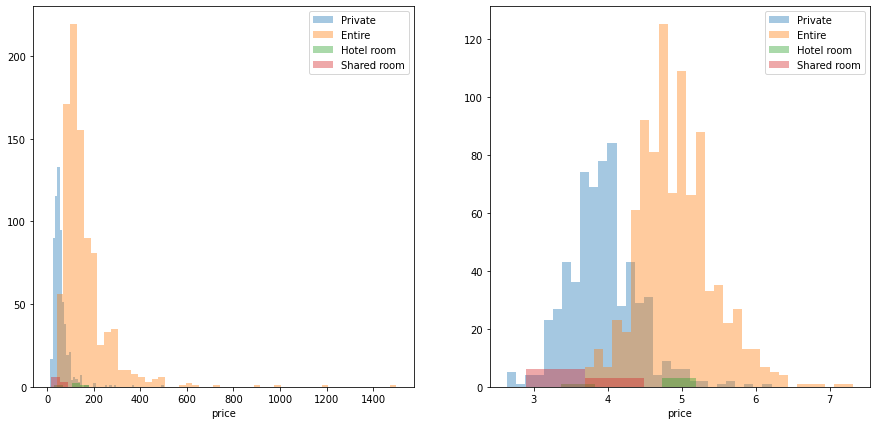

In [104]:
#Построим теперь 2 графика на одном
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))

sns.distplot(df6.query("room_type=='Private room'").price, ax=ax1, kde=False, label='Private')
sns.distplot(df6.query("room_type=='Entire home/apt'").price, ax=ax1, kde=False, label='Entire')
sns.distplot(df6.query("room_type=='Hotel room'").price, ax=ax1, kde=False, label='Hotel room')
sns.distplot(df6.query("room_type=='Shared room'").price, ax=ax1, kde=False, label='Shared room')
ax1.legend()

sns.distplot(np.log(df6.query("room_type=='Private room'").price), ax=ax2,kde=False, label='Private')
sns.distplot(np.log(df6.query("room_type=='Entire home/apt'").price), ax=ax2,kde=False, label='Entire')
sns.distplot(np.log(df6.query("room_type=='Hotel room'").price), ax=ax2,kde=False, label='Hotel room')
sns.distplot(np.log(df6.query("room_type=='Shared room'").price), ax=ax2,kde=False, label='Shared room')

ax2.legend()
plt.show()



In [ ]:
#Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года
#Ограничение поставьте на 1000 строк.
#Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) 
#в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [76]:
query7= """
SELECT 
    room_type,
    toFloat32OrNull(replaceAll(replaceAll(price, ',',''), '$', '')) price,
    first_review
FROM default.ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""

In [77]:
df7 = ph.read_clickhouse(query7, connection = connection)
df7.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [78]:
df7.dtypes

room_type        object
price           float32
first_review     object
dtype: object

In [80]:
df7['first_review'] = pd.to_datetime(df7.first_review)

In [82]:
df7['Year'] = df7.first_review.dt.year

In [87]:
df7 = df7.drop('first_review', axis = 1)
df7.head()

,room_type,price,Year
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


In [110]:
df7_new = df7.groupby(['Year', 'room_type'], as_index =False).agg({'price': 'mean'})
df7_new.head()

,Year,room_type,price
0,2010,Entire home/apt,103.500000
1,2010,Hotel room,88.000000
2,2010,Private room,56.428570
3,2011,Entire home/apt,128.792450
4,2011,Private room,52.607143


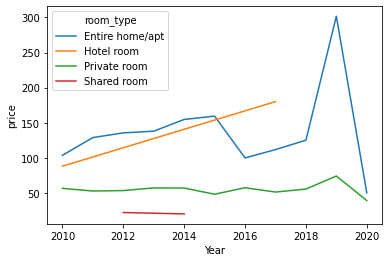

In [111]:
sns.lineplot(data = df7_new, y = 'price', x = 'Year', hue = 'room_type')